### Speech recognition model type: Sequence-to-sequence (Seq2Seq) encoder-decoder models with a cross-attention mechanism between the encoder and decoder/linked via a cross-attention mechanism

Encoder ('Acoustic-only'): Forms hidden-state representations from the audio inputs. For encoder only models, a linear layer is added that maps the hidden-state to characters. The system bases its prediction on the acoustic input it was given (the phonetic sounds of the audio) and therefore has a tendency to transcribe audio in a phonetic way (e.g. CHRISTMAUS). It gives less importance to the language modelling context of previous and successive letters, and so is prone to phonetic spelling errors

Decoder: Plays the role of a language model. It processes the entire sequence of hidden-state representations from the encoder and generates the corresponding text transcriptions. With the global context of the audio input, the decoder is able to use language modelling context as it makes its predictions, correcting for spelling mistakes on-the-fly and thus circumventing the issue of phonetic predictions.

## Whisper

Whisper is a pre-trained model for speech recognition. It is pre-trained on a vast quantity of labelled audio-transcription data, 680 000 hours worth (tackles challenge of Seq2Seq model being data hungry, requiring significantly more training data to reach convergence). 117 000 hours of this pre-training data is multilingual. 

Whisper models demonstrate a strong ability to generalise to many datasets and domains. The pre-trained checkpoints achieve competitive results to state-of-the-art pipe systems, with near 3% word error rate (WER) on the test-clean subset of LibriSpeech pipe and a new state-of-the-art on TED-LIUM with 4.7% WER

Whisper is 
- able to handle long-form audio samples
- robust to input noise 
- able to predict cased and punctuated transcriptions

Whisper checkpoints come in 5 configurations of varying model sizes. 

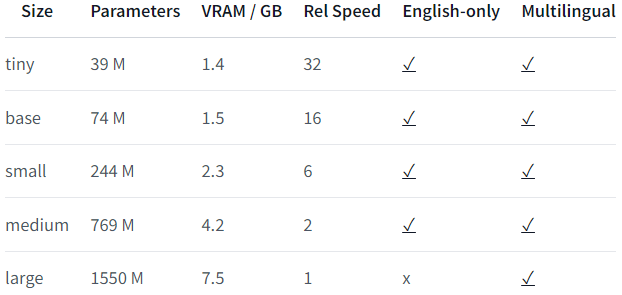

- 'English-only' and 'Multilingual' denote what the data the model was trained on 
- “VRAM” denotes the required GPU memory to run the model with the minimum batch size of 1
- “Rel Speed” is the relative speed of a checkpoint compared to the largest model



In [1]:
import torch
from transformers import pipeline

"""
Load the Whisper Base checkpoint 

The pipeline will take care of moving all inputs/outputs forom the CPU to the GPU as required
"""

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)

In [2]:
"""
Load a small exercept of the LibriSpeech ASR dataset     
"""

from datasets import load_dataset

dataset = load_dataset(
    "hf-internal-testing/librispeech_asr_dummy", "clean", split="validation"
)

In [3]:
dataset

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})

In [4]:
"""
Pick one of 73 audio samples and inspect the audio sample as well as the transcription
"""

from IPython.display import Audio

sample = dataset[2]

print(sample["text"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND


In [5]:
"""
Use the pipeline to transcribe the audio

Pass the argument max_new_tokens that tells the model the maximum number of tokens to generate when making its prediction
"""

pipe(sample["audio"], max_new_tokens=400)

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass 

{'text': ' He tells that this festive Season over Christmas, the Roast Beef looming before Us.'}

Using a larger Whisper checkpoint can help further reduce transcription errors, at the expense of requiring more compute and a longer transcription time

### Testing with multi languages

In [6]:
"""
The Multilingual LibriSpeech (MLS) dataset is the multilingual equivalent of the 
LibriSpeech dataset, with labelled audio data in six languages
"""

dataset = load_dataset(
    "facebook/multilingual_librispeech", "spanish", split="test", streaming=True
)
# load one sample from the Spanish split of the MLS dataset, making use of streaming mode so that we don’t have to download the entire dataset
sample = next(iter(dataset))

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
sample

{'audio': {'path': '11266_10604_000000.opus',
  'array': array([ 7.78957736e-04, -6.33661344e-04,  2.12675863e-04, ...,
          3.70796261e-05,  1.46979801e-05, -2.21978364e-04]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/poesias_1805_librivox/poesias_038_unamuno_64kb.mp3',
 'begin_time': 427.24,
 'end_time': 443.51,
 'transcript': 'y las almas buscando algún alivio se revuelven ansiosas y hacen el mundo que así resulta ser del dolor obra el dolor o la nada quien tenga corazón venga y escoja',
 'audio_duration': 16.269999999999982,
 'speaker_id': '11266',
 'chapter_id': '10604',
 'file': '11266_10604_000000.opus',
 'id': '11266_10604_000000'}

In [8]:
# Inspect the data
print(sample["transcript"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

y las almas buscando algún alivio se revuelven ansiosas y hacen el mundo que así resulta ser del dolor obra el dolor o la nada quien tenga corazón venga y escoja


In [19]:
"""
Note:

The pipeline consumes the dictionary of audio inputs that we input, 
meaning the dictionary can’t be re-used. 

To circumvent this, we’ll pass a copy of the audio sample, so that we can re-use the same audio sample


- The statement means that when you use the pipeline to process an audio sample provided as a dictionary, the pipeline may modify the contents of that dictionary during the processing. This modification means that the original dictionary is "consumed" or altered, and as a result, you cannot reuse the same dictionary in subsequent calls to the pipeline.


Setting the task to transcribe forces Whisper to perform speech recognition task, where     
the audio is transcribed in the same language that the speech was spoken in

Whisper is also capable of performing speech translation, generate_kwargs={"task": "translate"}
"""


pipe(sample["audio"].copy(), max_new_tokens=400, generate_kwargs={"task": "transcribe"})

{'text': ' Tribunal no levantes dentro de tu alma, manten la purha; ¿no tejusles el juzgio, oye a tu sancia?'}

### Long-Form Transcription and Timestamps

First, create a long audio file by concatenating sequential samples from the Multilingual LibriSpeech (MLS) dataset
- the MLS dataset is curated by splitting long audiobook recordings into shorter segments
- therefore concatenating samples is one way of reconstructing longer audiobook passages

In [16]:
"""
Getting One Long-Form Audio Sample  
"""

import numpy as np

# Set the target audio length to 5mins, stop concatenating samples once we hit this value
target_length_in_m = 5

# convert from minutes to seconds (* 60) to num samples (* sampling rate). Convert from minutes to num samples
# minutes * 60 * sampling_rate
sampling_rate = pipe.feature_extractor.sampling_rate
target_length_in_samples = target_length_in_m * 60 * sampling_rate

# iterate over our streaming dataset, concatenating samples until we hit our target
long_audio = []
for sample in dataset:
    long_audio.extend(sample["audio"]["array"])
    if len(long_audio) > target_length_in_samples:
        break

long_audio = np.asarray(long_audio)

# how did we do?
seconds = len(long_audio) / 16000
minutes, seconds = divmod(seconds, 60)
print(f"Length of audio sample is {minutes} minutes {seconds:.2f} seconds")

Length of audio sample is 5.0 minutes 8.85 seconds


Problems with the above:

1. ```Whisper is inherently designed to work with 30 second samples```: anything shorter than 30s is padded to 30s with silence, anything longer than 30s is truncated to 30s by cutting of the extra audio, so if we pass our audio directly we’ll only get the transcription for the first 30s

2. ```Memory in a transformer network scales with the sequence length squared```: doubling the input length quadruples the memory requirement, so passing super long audio files is bound to lead to an ```out-of-memory (OOM) error```

Luckily, we have ```chunking```

The way long-form transcription works in HuggingFace Transformers is by chunking the input audio into smaller, more manageable segments. 

Each segment has a small amount of overlap with the previous one. 

This allows us to accurately stitch the segments back together at the boundaries, since we can find the overlap between segments and merge the transcriptions accordingly

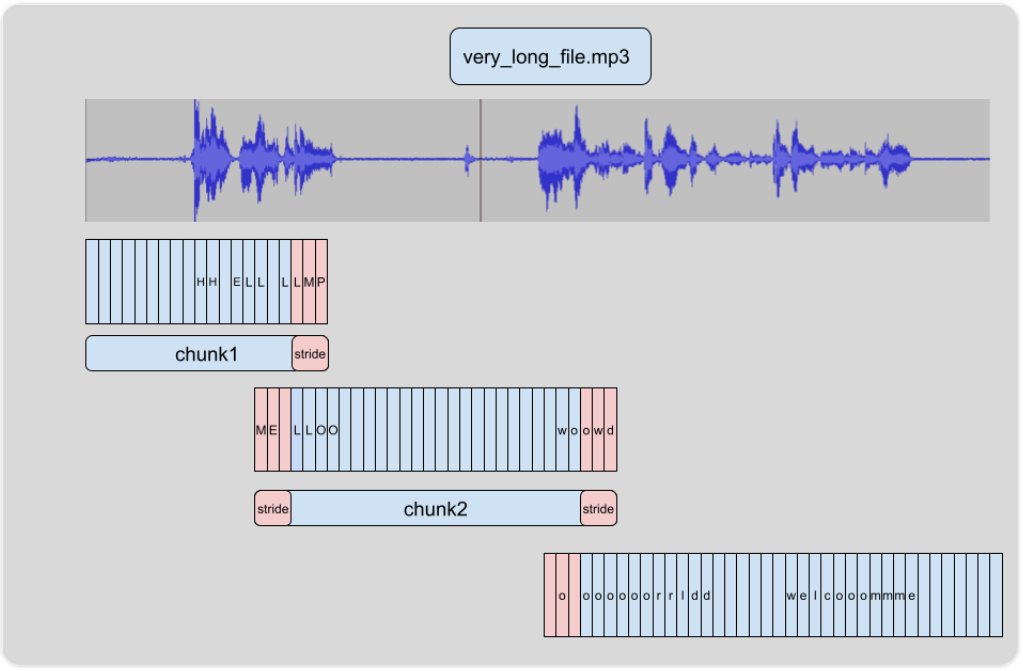



The advantage of chunking the samples is that we don’t need the result of ```chunk i``` to transcribe the subsequent ```chunk i+1```. 

The stitching is done after we have transcribed all the chunks at the chunk boundaries, so it doesn’t matter which order we transcribe chunks in. The algorithm is entirely stateless, so we can even do ```chunk i+1``` at the same time as ```chunk i```.

This allows us to batch the chunks and run them through the model in parallel, providing a large computational speed-up compared to transcribing them sequentially

More about ```chunking```: https://huggingface.co/blog/asr-chunking

In [ ]:
"""
Transcribe long audio sample with chunking and batching
Add one additional argument when we call the pipeline
- chunk_length_s controls the length of the chunked segment in seconds
- for Whisper, 30 second chunks are optimal, since this matches the input length Whisper expects

To activate batching, we need to pass the argument batch_size to the pipeline
"""

```
pipe(
    long_audio.copy(),
    max_new_tokens=448,
    generate_kwargs={"task": "transcribe"},
    chunk_length_s=30,
    batch_size=8,
)
```

Whisper is also able to predict segment-level timestamps for the audio data. These timestamps indicate the start and end time for a short passage of audio, and are particularly useful for aligning a transcription with the input audio. Suppose we want to provide closed captions for a video - we need these timestamps to know which part of the transcription corresponds to a certain segment of video, in order to display the correct transcription for that time.

Activating timestamp prediction is straightforward, we just need to set the argument return_timestamps=True. Timestamps are compatible with both the chunking and batching methods we used previously, so we can simply append the timestamp argument to our previous call

```
pipe(
    long_audio,
    max_new_tokens=256,
    generate_kwargs={"task": "transcribe"},
    chunk_length_s=30,
    batch_size=8,
    return_timestamps=True,
)["chunks"]

Output:

[{'timestamp': (0.0, 26.4),
  'text': ' Entonces te deleitarás en Jehová, y yo te haré subir sobre las alturas de la tierra, y te daré a comer la heredad de Jacob tu padre, porque la boca de Jehová lo ha hablado. nosotros curados. Todos nosotros nos descarriamos como bejas, cada cual se apartó por su camino,'},
 {'timestamp': (26.4, 32.48),
  'text': ' mas Jehová cargó en él el pecado de todos nosotros. No es que partas tu pan con el'},
 {'timestamp': (32.48, 38.4),
  'text': ' hambriento y a los hombres herrantes metas en casa, que cuando vieres al desnudo lo cubras y no'},
 ...
```

## The Way Forward

Whisper model works well on high-resource languages (those with more training data) but it has lower transcription and translation accuracy on low-resource languages (those with less training data) 

To boost performace on low-resource languages, we can take the pre-trained Whisper model and train it on a small corpus of appropriately selected data, in a process called fine-tuning. We’ll show that with as little as ten hours of additional data, we can improve the performance of the Whisper model by over 100% on a low-resource language